# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

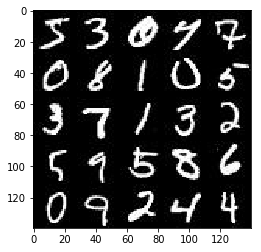

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

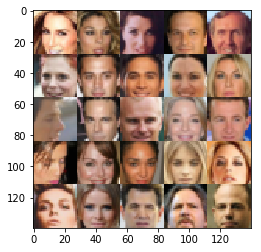

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [102]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return (
        tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="input_real"),
        tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z"),
        tf.placeholder(tf.float32, name="lr"),
    )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [103]:
import operator
import functools

relu_alpha = 0.2


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        k_initializer = tf.random_normal_initializer(stddev=0.05)
        h1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        h1 = tf.maximum(relu_alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 256, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        h2 = tf.layers.batch_normalization(h2, training=True)  # not reuse
        h2 = tf.maximum(relu_alpha * h2, h2)
    
        h3 = tf.layers.conv2d(h2, 512, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        h3 = tf.layers.batch_normalization(h3, training=True)  # not reuse
        h3 = tf.maximum(relu_alpha * h3, h3)
        
        flatten = tf.reshape(h3, (-1, functools.reduce(operator.mul, map(int, h3.shape[1:]), 1)))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [105]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        h1 = tf.layers.dense(z, 7 * 7 * 512)
        
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(relu_alpha * h1, h1)
        
        k_initializer = tf.random_normal_initializer(stddev=0.05)
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(relu_alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding='same', kernel_initializer=k_initializer)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(relu_alpha * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=k_initializer)
        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [106]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    d_model, d_logits = discriminator(input_real)
    d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits, labels=tf.ones_like(d_model))
    )
    
    g_model = generator(input_z, out_channel_dim)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss += tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [107]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.startswith("generator")]
    d_vars = [v for v in t_vars if v.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    while tf.control_dependencies(update_ops):
        return (
            tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars),
            tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        )

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [108]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [123]:
print_loss_after = 20
plot_output_after = 100


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    counter = 0
    total_batch_steps = 'unknown'
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_step, batch_images in enumerate(get_batches(batch_size)):
                
                counter += 1
                batch_images = batch_images * 2
              
                noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                d_feed_dict = {input_real: batch_images, input_z: noise, lr: learning_rate}
                g_feed_dict = {input_z: noise, lr: learning_rate}
                
                sess.run(d_opt, feed_dict=d_feed_dict)
                sess.run(g_opt, feed_dict=g_feed_dict)
                
                if counter % print_loss_after == 0:
                    d_train_loss = d_loss.eval(d_feed_dict)
                    g_train_loss = g_loss.eval(g_feed_dict)
                    
                    print("Step {}/{} of Epoch {}/{}, d_loss: {:.4f}, g_loss {:.4f}".format(
                        batch_step + 1, total_batch_steps, epoch_i + 1, epoch_count, d_train_loss, g_train_loss
                    ))
                    
                if counter % plot_output_after == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
            total_batch_steps = batch_step
                    
        d_actual_loss = d_loss.eval(d_feed_dict)
        g_actual_loss = g_loss.eval(g_feed_dict)
                    
        print("d_loss: {:.4f}, g_loss {:.4f}".format(d_actual_loss, g_actual_loss))
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

        saver = tf.train.Saver()
        saver.save(sess, './checkpoint.ckpt')

    print("Traing Finished & Saved")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 20/unknown of Epoch 1/2, d_loss: 0.0136, g_loss 12.3837
Step 40/unknown of Epoch 1/2, d_loss: 7.0716, g_loss 0.0170
Step 60/unknown of Epoch 1/2, d_loss: 2.2711, g_loss 5.4774
Step 80/unknown of Epoch 1/2, d_loss: 1.0636, g_loss 3.1149
Step 100/unknown of Epoch 1/2, d_loss: 0.8961, g_loss 0.8000


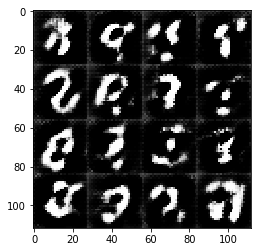

Step 120/unknown of Epoch 1/2, d_loss: 0.6891, g_loss 1.4888
Step 140/unknown of Epoch 1/2, d_loss: 0.9501, g_loss 2.2941
Step 160/unknown of Epoch 1/2, d_loss: 1.5957, g_loss 0.4800
Step 180/unknown of Epoch 1/2, d_loss: 2.6472, g_loss 0.1376
Step 200/unknown of Epoch 1/2, d_loss: 1.2467, g_loss 0.6771


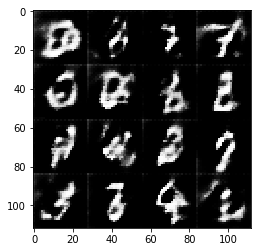

Step 220/unknown of Epoch 1/2, d_loss: 0.9022, g_loss 0.9906
Step 240/unknown of Epoch 1/2, d_loss: 1.3425, g_loss 0.4386
Step 260/unknown of Epoch 1/2, d_loss: 1.0086, g_loss 1.7739
Step 280/unknown of Epoch 1/2, d_loss: 1.1401, g_loss 0.7621
Step 300/unknown of Epoch 1/2, d_loss: 1.6864, g_loss 0.2947


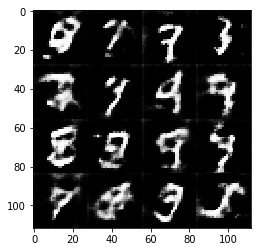

Step 320/unknown of Epoch 1/2, d_loss: 1.2758, g_loss 0.5953
Step 340/unknown of Epoch 1/2, d_loss: 1.1060, g_loss 0.8077
Step 360/unknown of Epoch 1/2, d_loss: 1.2500, g_loss 0.5021
Step 380/unknown of Epoch 1/2, d_loss: 1.0749, g_loss 1.5031
Step 400/unknown of Epoch 1/2, d_loss: 0.9912, g_loss 1.3611


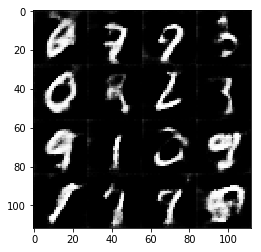

Step 420/unknown of Epoch 1/2, d_loss: 1.0544, g_loss 0.6635
Step 440/unknown of Epoch 1/2, d_loss: 0.9916, g_loss 0.8833
Step 460/unknown of Epoch 1/2, d_loss: 0.9870, g_loss 0.9635
Step 12/467 of Epoch 2/2, d_loss: 1.0890, g_loss 0.6049
Step 32/467 of Epoch 2/2, d_loss: 1.4514, g_loss 0.4863


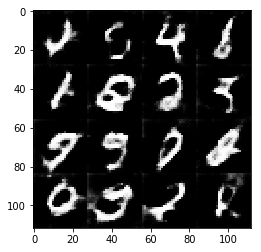

Step 52/467 of Epoch 2/2, d_loss: 1.4523, g_loss 0.3937
Step 72/467 of Epoch 2/2, d_loss: 1.2589, g_loss 0.5295
Step 92/467 of Epoch 2/2, d_loss: 1.0280, g_loss 2.1636
Step 112/467 of Epoch 2/2, d_loss: 1.0362, g_loss 1.1731
Step 132/467 of Epoch 2/2, d_loss: 2.0481, g_loss 0.1899


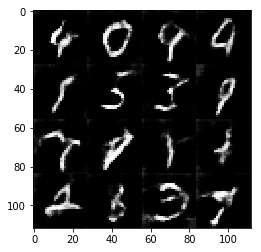

Step 152/467 of Epoch 2/2, d_loss: 0.9858, g_loss 1.3011
Step 172/467 of Epoch 2/2, d_loss: 1.4194, g_loss 0.4271
Step 192/467 of Epoch 2/2, d_loss: 1.5870, g_loss 0.3691
Step 212/467 of Epoch 2/2, d_loss: 1.8908, g_loss 2.2288
Step 232/467 of Epoch 2/2, d_loss: 1.0007, g_loss 0.9065


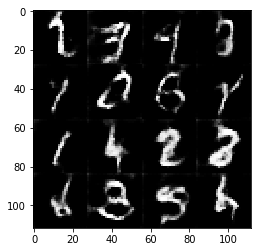

Step 252/467 of Epoch 2/2, d_loss: 0.9449, g_loss 1.4148
Step 272/467 of Epoch 2/2, d_loss: 1.2440, g_loss 2.3667
Step 292/467 of Epoch 2/2, d_loss: 0.9315, g_loss 0.8925
Step 312/467 of Epoch 2/2, d_loss: 1.8063, g_loss 0.2606
Step 332/467 of Epoch 2/2, d_loss: 2.3168, g_loss 2.7709


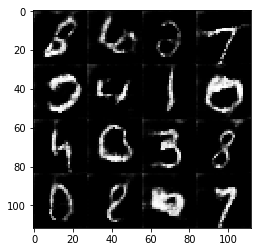

Step 352/467 of Epoch 2/2, d_loss: 1.1123, g_loss 0.9505
Step 372/467 of Epoch 2/2, d_loss: 0.9430, g_loss 1.4434
Step 392/467 of Epoch 2/2, d_loss: 0.9698, g_loss 0.8899
Step 412/467 of Epoch 2/2, d_loss: 1.1603, g_loss 1.5380
Step 432/467 of Epoch 2/2, d_loss: 1.2145, g_loss 1.5050


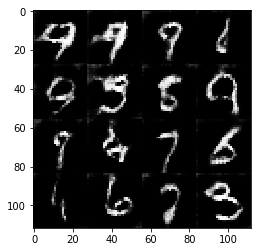

Step 452/467 of Epoch 2/2, d_loss: 0.9832, g_loss 1.0699
d_loss: 0.8318, g_loss 1.4218


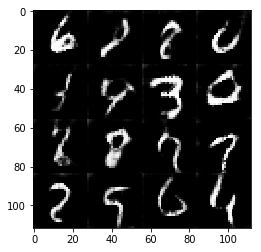

Traing Finished & Saved


In [125]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
0
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 20/unknown of Epoch 1/1, d_loss: 0.5129, g_loss 14.6698
Step 40/unknown of Epoch 1/1, d_loss: 1.1888, g_loss 5.6889
Step 60/unknown of Epoch 1/1, d_loss: 0.2585, g_loss 2.2395
Step 80/unknown of Epoch 1/1, d_loss: 0.2549, g_loss 6.0041
Step 100/unknown of Epoch 1/1, d_loss: 0.1064, g_loss 3.4238


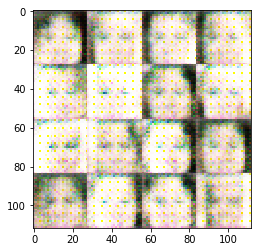

Step 120/unknown of Epoch 1/1, d_loss: 0.1805, g_loss 2.4662
Step 140/unknown of Epoch 1/1, d_loss: 1.7763, g_loss 0.6015
Step 160/unknown of Epoch 1/1, d_loss: 1.5872, g_loss 0.5304
Step 180/unknown of Epoch 1/1, d_loss: 1.4054, g_loss 0.5600
Step 200/unknown of Epoch 1/1, d_loss: 1.0136, g_loss 0.8858


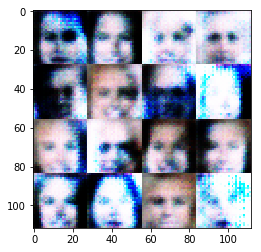

Step 220/unknown of Epoch 1/1, d_loss: 1.4412, g_loss 0.8044
Step 240/unknown of Epoch 1/1, d_loss: 1.2825, g_loss 0.7135
Step 260/unknown of Epoch 1/1, d_loss: 1.0968, g_loss 0.8422
Step 280/unknown of Epoch 1/1, d_loss: 1.3749, g_loss 2.6717
Step 300/unknown of Epoch 1/1, d_loss: 0.9179, g_loss 0.9186


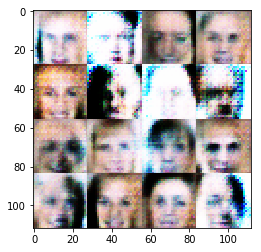

Step 320/unknown of Epoch 1/1, d_loss: 1.2386, g_loss 4.2506
Step 340/unknown of Epoch 1/1, d_loss: 0.7164, g_loss 1.8727
Step 360/unknown of Epoch 1/1, d_loss: 2.1067, g_loss 3.5712
Step 380/unknown of Epoch 1/1, d_loss: 1.5855, g_loss 0.9437
Step 400/unknown of Epoch 1/1, d_loss: 0.8433, g_loss 0.7701


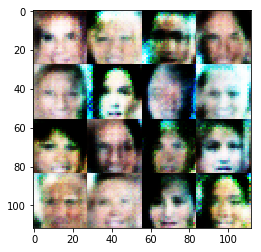

Step 420/unknown of Epoch 1/1, d_loss: 0.8517, g_loss 0.9290
Step 440/unknown of Epoch 1/1, d_loss: 1.7591, g_loss 0.2605
Step 460/unknown of Epoch 1/1, d_loss: 1.7993, g_loss 0.4495
Step 480/unknown of Epoch 1/1, d_loss: 1.2493, g_loss 0.8565
Step 500/unknown of Epoch 1/1, d_loss: 1.2379, g_loss 1.0776


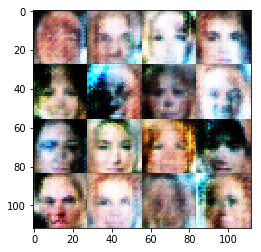

Step 520/unknown of Epoch 1/1, d_loss: 0.7309, g_loss 3.7596
Step 540/unknown of Epoch 1/1, d_loss: 0.6918, g_loss 1.4769
Step 560/unknown of Epoch 1/1, d_loss: 1.0954, g_loss 2.5012
Step 580/unknown of Epoch 1/1, d_loss: 1.3735, g_loss 0.3713
Step 600/unknown of Epoch 1/1, d_loss: 1.4241, g_loss 1.3322


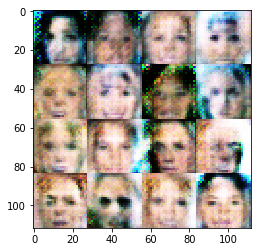

Step 620/unknown of Epoch 1/1, d_loss: 1.0450, g_loss 0.6164
Step 640/unknown of Epoch 1/1, d_loss: 1.3487, g_loss 2.3368
Step 660/unknown of Epoch 1/1, d_loss: 1.4412, g_loss 0.3901
Step 680/unknown of Epoch 1/1, d_loss: 1.2200, g_loss 0.8315
Step 700/unknown of Epoch 1/1, d_loss: 0.8975, g_loss 0.9990


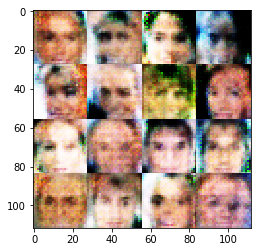

Step 720/unknown of Epoch 1/1, d_loss: 1.4853, g_loss 1.0030
Step 740/unknown of Epoch 1/1, d_loss: 1.2847, g_loss 0.9942
Step 760/unknown of Epoch 1/1, d_loss: 0.5799, g_loss 1.7647
Step 780/unknown of Epoch 1/1, d_loss: 0.8994, g_loss 1.6747
Step 800/unknown of Epoch 1/1, d_loss: 1.0890, g_loss 0.7217


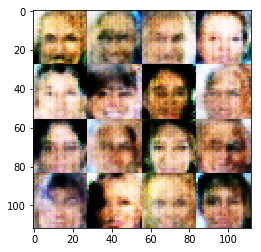

Step 820/unknown of Epoch 1/1, d_loss: 1.4967, g_loss 0.4371
Step 840/unknown of Epoch 1/1, d_loss: 1.7520, g_loss 2.2225
Step 860/unknown of Epoch 1/1, d_loss: 1.6941, g_loss 0.6053
Step 880/unknown of Epoch 1/1, d_loss: 1.4597, g_loss 0.6582
Step 900/unknown of Epoch 1/1, d_loss: 1.0618, g_loss 0.5758


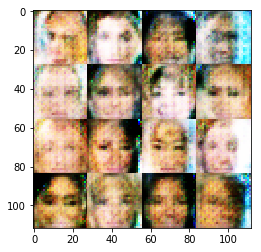

Step 920/unknown of Epoch 1/1, d_loss: 0.9242, g_loss 0.8467
Step 940/unknown of Epoch 1/1, d_loss: 1.5172, g_loss 0.4024
Step 960/unknown of Epoch 1/1, d_loss: 0.8477, g_loss 1.8716
Step 980/unknown of Epoch 1/1, d_loss: 0.9443, g_loss 0.8633
Step 1000/unknown of Epoch 1/1, d_loss: 1.7386, g_loss 0.8896


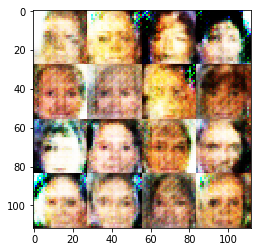

Step 1020/unknown of Epoch 1/1, d_loss: 1.6528, g_loss 0.2762
Step 1040/unknown of Epoch 1/1, d_loss: 1.0287, g_loss 0.8260
Step 1060/unknown of Epoch 1/1, d_loss: 0.9368, g_loss 0.7618
Step 1080/unknown of Epoch 1/1, d_loss: 1.1846, g_loss 0.8684
Step 1100/unknown of Epoch 1/1, d_loss: 1.3628, g_loss 1.2841


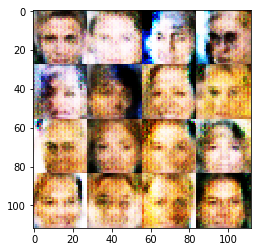

Step 1120/unknown of Epoch 1/1, d_loss: 0.7768, g_loss 1.4035
Step 1140/unknown of Epoch 1/1, d_loss: 0.9976, g_loss 1.2738
Step 1160/unknown of Epoch 1/1, d_loss: 1.1564, g_loss 1.5133
Step 1180/unknown of Epoch 1/1, d_loss: 1.0902, g_loss 1.4009
Step 1200/unknown of Epoch 1/1, d_loss: 1.3069, g_loss 0.4668


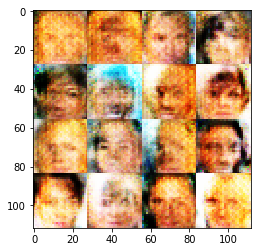

Step 1220/unknown of Epoch 1/1, d_loss: 1.3503, g_loss 1.5308
Step 1240/unknown of Epoch 1/1, d_loss: 1.1341, g_loss 0.7669
Step 1260/unknown of Epoch 1/1, d_loss: 1.0582, g_loss 1.0627
Step 1280/unknown of Epoch 1/1, d_loss: 1.5699, g_loss 0.3712
Step 1300/unknown of Epoch 1/1, d_loss: 1.3137, g_loss 0.7660


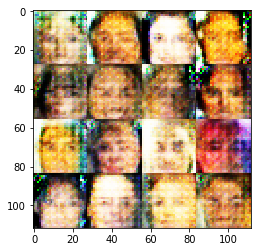

Step 1320/unknown of Epoch 1/1, d_loss: 1.4714, g_loss 0.7463
Step 1340/unknown of Epoch 1/1, d_loss: 1.0238, g_loss 0.7171
Step 1360/unknown of Epoch 1/1, d_loss: 0.9810, g_loss 0.9347
Step 1380/unknown of Epoch 1/1, d_loss: 0.9418, g_loss 1.4455
Step 1400/unknown of Epoch 1/1, d_loss: 0.9395, g_loss 1.1333


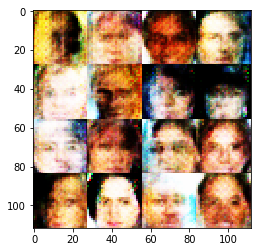

Step 1420/unknown of Epoch 1/1, d_loss: 0.8748, g_loss 3.0180
Step 1440/unknown of Epoch 1/1, d_loss: 0.6227, g_loss 1.7568
Step 1460/unknown of Epoch 1/1, d_loss: 1.0550, g_loss 0.6603
Step 1480/unknown of Epoch 1/1, d_loss: 1.4292, g_loss 2.0547
Step 1500/unknown of Epoch 1/1, d_loss: 0.9867, g_loss 1.3589


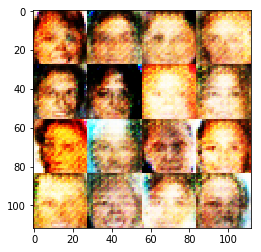

Step 1520/unknown of Epoch 1/1, d_loss: 1.2063, g_loss 1.0372
Step 1540/unknown of Epoch 1/1, d_loss: 1.0726, g_loss 0.9152
Step 1560/unknown of Epoch 1/1, d_loss: 1.4423, g_loss 0.4077
Step 1580/unknown of Epoch 1/1, d_loss: 1.1790, g_loss 0.6962
d_loss: 1.2518, g_loss 0.4987


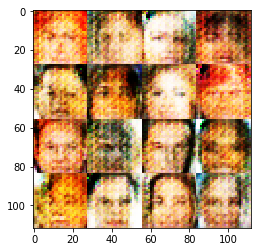

Traing Finished & Saved


In [126]:
batch_size = 128
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.